# Uebung 2

# 2) Eigengesichter

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mp
import tarfile
import os.path
import urllib.request
import skimage

In [2]:
filename = "lfw-funneled.tgz"
url = "http://vis-www.cs.umass.edu/lfw/" + filename
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)
    dateDownloaded = !date
    print(dateDownloaded)

In [3]:
tar = tarfile.open(filename)
tar.extractall()
tar.close()
foldername = "lfw_funneled"

In [5]:
persons = {}
for personName in os.listdir(foldername):
    current_person = foldername + "/" + personName
    if os.path.isdir(current_person):
        if len(os.listdir(current_person)) >= 70:
               persons.update({personName: [current_person +"/"+item for item in os.listdir(current_person)] })
persons.keys()

dict_keys(['Tony_Blair', 'Gerhard_Schroeder', 'Hugo_Chavez', 'George_W_Bush', 'Ariel_Sharon', 'Donald_Rumsfeld', 'Colin_Powell'])

lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0071.jpg


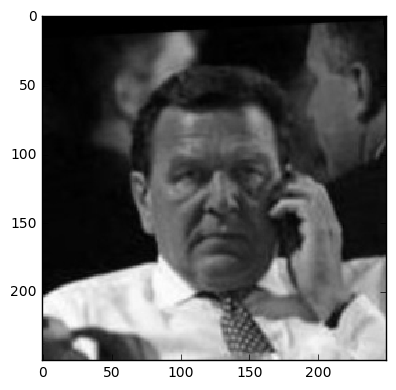

In [33]:
from skimage import io

path = persons['Gerhard_Schroeder'][0]
print(path)
image = io.imread(path, as_grey=True)
io.imshow(image)
io.show()
#for person in persons.values():
#    for picture_path in person:
#        picture = io.imread(picture_path)
        

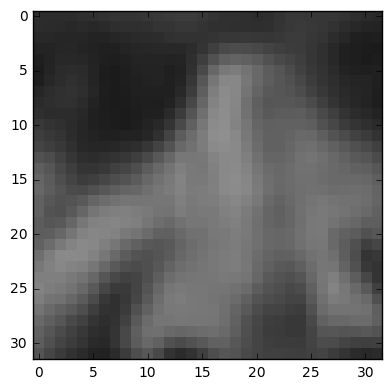

In [34]:
cropped_image_size = 32
dimensions = image.shape
startX = int((dimensions[0] - cropped_image_size) / 2)
startY = int((dimensions[1] - cropped_image_size) / 2)
cropped = image[startX:(startX + cropped_image_size), startY:(startY + cropped_image_size)]
io.imshow(cropped)
io.show()